In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\cat-in-dat-2-stack.ipynb
.\sample_submission.csv
.\test.csv
.\train.csv


In [4]:
submission = pd.read_csv('sample_submission.csv', index_col='id')

In [9]:
submission.head()

,target
id,
600000,0.5
600001,0.5
600002,0.5
600003,0.5
600004,0.5


In [11]:
kernels = pd.read_csv('kernels/kernels.csv', index_col='id')

In [12]:
kernels.head(10)

,kernel,version,score
id,,,
1,https://www.kaggle.com/siavrez/deepfm-model,15,0.78620
2,https://www.kaggle.com/springmanndaniel/keras-...,6,0.78626
3,https://www.kaggle.com/abhishek/same-old-entit...,4,0.78623
4,https://www.kaggle.com/lucamassaron/catboost-i...,15,0.78563
5,https://www.kaggle.com/pavelvpster/cat-in-dat-...,9,0.78586
6,https://www.kaggle.com/siavrez/libffm-stratifi...,1,0.78531
7,https://www.kaggle.com/shubhamlekhwar/categori...,1,0.78639


In [14]:
import glob

def make_filename(idx):
    return glob.glob('kernels/' + str(idx) + '__submission.csv')[0]

def read_predictions(idx):
    temp = pd.read_csv(make_filename(idx), index_col='id')
    temp.columns = [str(idx)]
    return temp


predictions = pd.concat([read_predictions(idx) for idx in kernels.index], axis=1)
predictions.shape

(400000, 7)

In [16]:
kernels.index

Int64Index([1, 2, 3, 4, 5, 6, 7], dtype='int64', name='id')

In [15]:
predictions.head()

,1,2,3,4,5,6,7
id,,,,,,,
600000,0.113295,0.141576,0.143216,0.145981,0.146665,0.120515,0.139188
600001,0.251375,0.277705,0.281658,0.275675,0.280411,0.217621,0.276149
600002,0.151903,0.170349,0.178905,0.165126,0.163589,0.155778,0.177261
600003,0.107350,0.144562,0.158748,0.125980,0.113939,0.129859,0.152639
600004,0.126612,0.161857,0.178045,0.141698,0.157558,0.129353,0.165082


In [30]:
a = predictions['1']

In [37]:
b = a.value_counts()

In [44]:
pd.DataFrame(b).info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 399966 entries, 0.12112302775494754 to 0.2509763115085661
Data columns (total 1 columns):
1    399966 non-null int64
dtypes: int64(1)
memory usage: 6.1 MB


## Distribution

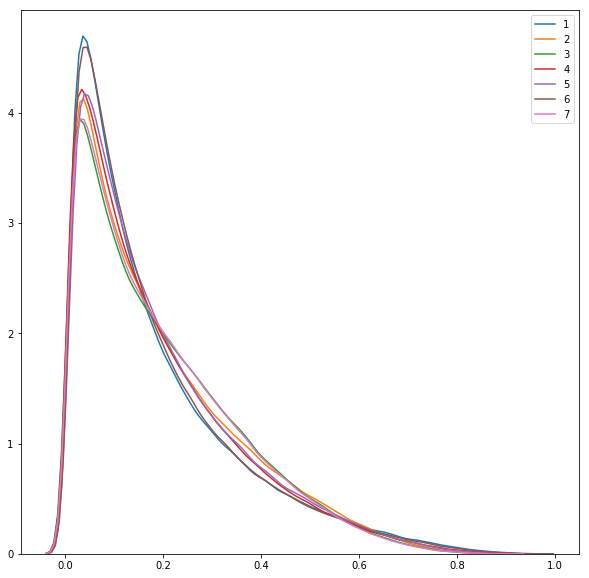

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10,10))

for column in predictions.columns:
    sns.kdeplot(predictions[column], label=column)

plt.show()

## Correlation matrix

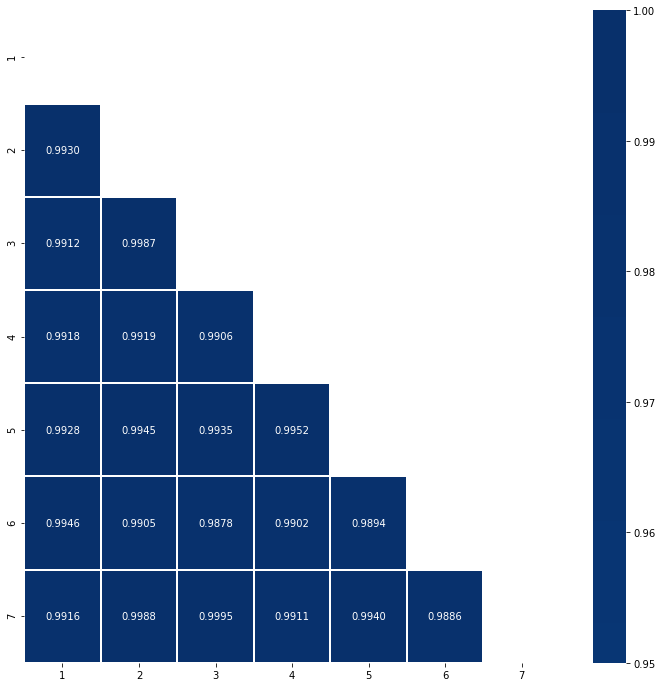

In [45]:
# From https://seaborn.pydata.org/examples/many_pairwise_correlations.html

import seaborn as sns
import matplotlib.pyplot as plt

corr = predictions.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(corr, mask=mask, cmap='Blues', vmin=0.95, center=0, linewidths=1, annot=True, fmt='.4f')

plt.show()

## Stack

In [46]:
submission['target'] = predictions.mean(axis=1)
submission.to_csv('stack-mean.csv')

In [47]:
submission.head()

,target
id,
600000,0.135777
600001,0.265799
600002,0.166130
600003,0.133297
600004,0.151458


## Weighted sum

In [48]:
scores = kernels['score']

sum_scores = sum(scores)

weights = [x / sum_scores for x in scores]

In [49]:
weighted_sum_prediction = predictions.dot(pd.Series(weights, index=predictions.columns))

In [50]:
weighted_sum_prediction.head()

id
600000    0.135778
600001    0.265806
600002    0.166133
600003    0.133300
600004    0.151463
dtype: float64

In [51]:
submission['target'] = weighted_sum_prediction
submission.to_csv('stack-weighted-sum.csv')

## Blend by ranking

In [53]:
scores = kernels['score']

sum_scores = sum(scores)

weights = [x / sum_scores for x in scores]

In [54]:
weights

[0.14289660988607528,
 0.14290751524933296,
 0.1429020625677041,
 0.1427930089351276,
 0.14283481282761526,
 0.1427348469977535,
 0.14293114353639116]

In [55]:
from scipy.stats import rankdata


def blend_by_ranking(data, weights):
    out = np.zeros(data.shape[0])
    for idx,column in enumerate(data.columns):
        out += weights[idx] * rankdata(data[column].values)
    out /= np.max(out)
    return out

In [56]:
blend_by_ranking_prediction = blend_by_ranking(predictions, weights)

In [57]:
blend_by_ranking_prediction

array([0.4706712 , 0.72926153, 0.54547558, ..., 0.95034017, 0.74502927,
       0.66558825])

In [58]:
submission['target'] = blend_by_ranking_prediction
submission.to_csv('stack-blend-by-ranking.csv')